In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random

# Check if the current working directory is the notebooks directory
if 'notebooks' in os.path.basename(os.getcwd()):
    # Change directory to the parent of notebooks
    %cd ..
    print("Changed working directory to the project root:", os.getcwd())
else:
    print("Working directory:", os.getcwd())

c:\Users\sghys\My Drive (sghyseli@student.ubc.ca)\ComputerVision
Changed working directory to the project root: c:\Users\sghys\My Drive (sghyseli@student.ubc.ca)\ComputerVision


Shape of images: (50000, 32, 32, 3)
Shape of labels: 50000


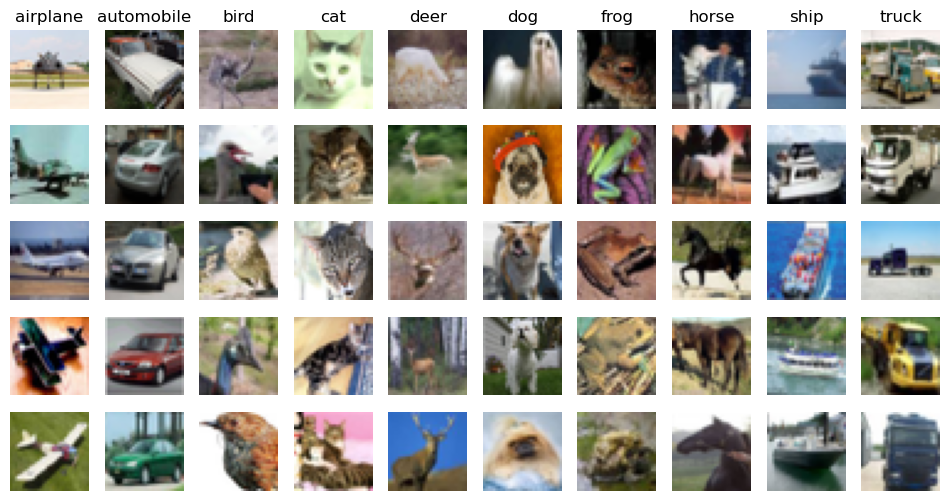

In [2]:
from utils.load_data import load_cifar10

data, labels, data_test, labels_test, label_names = load_cifar10()

# Reshaping the data to a more manageable format (10000, 32, 32, 3)
images = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
images_test = data_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

# Verifying the shape of images and labels
print(f"Shape of images: {images.shape}")
print(f"Shape of labels: {len(labels)}")

# Number of classes and number of samples per class to display
num_classes = 10
samples_per_class = 5

# show some examples of each class to make sure the data is correct
plt.figure(figsize=(12, 6))
for cls in range(num_classes):
    idxs = [i for i, lbl in enumerate(labels) if lbl == cls]
    random_idxs = random.sample(idxs, samples_per_class)
    
    for i, idx in enumerate(random_idxs):
        # Calculate the position of the subplot
        plt_idx = i * num_classes + cls + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(images[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            # Label only the first row
            plt.title(label_names[cls])

plt.show()

# Build a CNN Model
Input: 3x32x32 RGB image
The np arrays need to be converted over to PyTorch tensors. The RGB color channel is shifted to second position to match the format for using nn.


PyTorch can use cuda on GPU if available. Tasks need to be specifcally sent to the GPU if it is going to be used for this purpose. The best way to do this is to determine the optimal hardware that is a available at runtime and send to that device.

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Reshaping the images from (N, 32, 32, 3) to (N, 3, 32, 32)
images_cnn = images.transpose(0, 3, 1, 2)
images_test_cnn = images_test.transpose(0, 3, 1, 2)

# Convert the numpy arrays to PyTorch tensors
X = torch.tensor(images_cnn, dtype=torch.float32)
X_test = torch.tensor(images_test_cnn, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.long)
y_test = torch.tensor(labels_test, dtype=torch.long)

print(f"Shape of images for CNN: {X.shape} {X.dtype}")
print(f"Shape of labels for CNN: {y.shape} {y.dtype}")
print(f"Class of labels for CNN: {label_names}")

# Create tensor datasets
train_dataset = TensorDataset(X, y)
test_dataset = TensorDataset(X_test, y_test)

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Shape of images for CNN: torch.Size([50000, 3, 32, 32]) torch.float32
Shape of labels for CNN: torch.Size([50000]) torch.int64
Class of labels for CNN: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Using cuda device


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(3, 3))
    (4): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


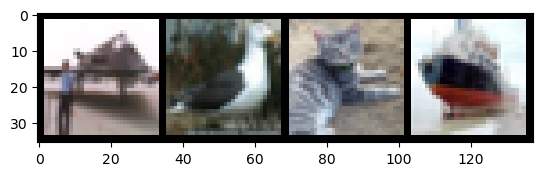

In [4]:
import torchvision 
import torchvision.transforms as transforms
from models.cnn import CNN

# Create data loaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Extract a batch of 4 images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)).astype('uint8'))

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=False)

model = CNN().to(device)
print(model)



### Visualize the model
A basic ASCII summary to check dimension and parameters 

In [5]:
from pytorch_model_summary import summary

# Print the summary of the model
print(summary(model, torch.zeros((1, 3, 32, 32)).to(device), show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 32, 32]           2,432           2,432
            ReLU-2     [1, 32, 32, 32]               0               0
       MaxPool2d-3     [1, 32, 32, 32]               0               0
          Conv2d-4     [1, 32, 16, 16]          51,264          51,264
            ReLU-5       [1, 64, 4, 4]               0               0
         Flatten-6       [1, 64, 4, 4]               0               0
          Linear-7           [1, 1024]         524,800         524,800
            ReLU-8            [1, 512]               0               0
          Linear-9            [1, 512]          65,664          65,664
           ReLU-10            [1, 128]               0               0
         Linear-11            [1, 128]           1,290           1,290
Total params: 645,450
Trainable params: 645,450
Non-trainable params: 0
----

In [6]:
from torchviz import make_dot

# Create a dummy image input for the CNN
dummy_input = torch.randn(1, 3, 32, 32, device=device)

# Forward pass through the model
output = model(dummy_input)

# Visualize the graph
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("cnn_architecture", format="png")

# Display the graph inline
# display(dot)


'cnn_architecture.png'

In [7]:

# from torch.utils.tensorboard.writer import SummaryWriter

# # Create a SummaryWriter
# writer = SummaryWriter('runs/cnn_experiment_1')

# # Write the model graph
# writer.add_graph(model, dummy_input)
# writer.close()

# # You can now view the TensorBoard by launching it in your terminal
# # tensorboard --logdir=runs


## Training


In [8]:
from torch.utils.data import random_split
# Split the training dataset into 90% training and 10% validation
# Check Size of dataset
total_train_samples = len(train_dataset)
val_size = int(0.1 * total_train_samples)
train_size = total_train_samples - val_size

# Split the dataset
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


In [9]:
import torch.nn as nn

import wandb

wandb.init(project="cifar10", entity="sghyseli", config={
    "learning_rate": 0.001,
    "epochs": 25,
    "batch_size": 4,
    "num_classes": 10,
    "shuffle": True
})
config = wandb.config

# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=config.shuffle)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Cross Entropy for multi-class classification (LogSoftmax + NLLLoss)
# This will give probabilities for each class
criterion = nn.CrossEntropyLoss()
# Specify weight decay in the optimizer for L2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=1e-5)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sghyseli. Use `wandb login --relogin` to force relogin


Training set size: 45000
Validation set size: 5000


In [10]:
from utils.training import train_one_epoch, validate

best_val_accuracy = 0.0
for epoch in range(config.epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)

    # Log metrics to wandb
    wandb.log({"epoch": epoch, "train_loss": train_loss, "train_accuracy": train_accuracy, "val_loss": val_loss, "val_accuracy": val_accuracy})

    print(f"Epoch {epoch + 1}/{config.epochs}: Train Loss {train_loss:.4f}, Train Accuracy {train_accuracy:.4f}, Val Loss {val_loss:.4f}, Val Accuracy {val_accuracy:.4f}")

    # Save model checkpoint if it's the best so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        model_path = f"data/models/best_model_{epoch+1}.pth"
        torch.save(model.state_dict(), model_path)
        
wandb.finish()


Epoch 1/25: Train Loss 2.0216, Train Accuracy 0.2409, Val Loss 1.8466, Val Accuracy 0.2788
Epoch 2/25: Train Loss 1.8264, Train Accuracy 0.3250, Val Loss 1.7686, Val Accuracy 0.3296
Epoch 3/25: Train Loss 1.7432, Train Accuracy 0.3622, Val Loss 1.7132, Val Accuracy 0.3810
Epoch 4/25: Train Loss 1.6904, Train Accuracy 0.3856, Val Loss 1.7099, Val Accuracy 0.3630
